In [3]:
## Dependencies
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
## Importing Data
filepath = r'/Users/sofia/Desktop/ML_GEO/RGI2000-v7.0-G-01_alaska-attributes.csv'

ds_alaska = pd.read_csv(filepath)

# display(ds_alaska.head())

ds_alaska = ds_alaska.drop(['src_date', 'rgi_id', 'o1region', 'o2region', 'glims_id', 'anlys_id', 'primeclass', 'conn_lvl', 'subm_id', 'utm_zone', 'glac_name', 'dem_source'], axis=1)
ds_alaska = ds_alaska.drop(['zmin_m','zmax_m', 'zmed_m', 'zmean_m'], axis=1)
ds_alaska = ds_alaska.drop(['lmax_m'], axis = 1)
display(ds_alaska.head())

,cenlon,cenlat,area_km2,surge_type,term_type,is_rgi6,termlon,termlat,slope_deg,aspect_deg,aspect_sec
0,-155.909404,67.413726,0.239199,0,9,1,-155.904032,67.416034,17.606613,342.330469,1
1,-155.879114,67.419232,0.104641,0,9,1,-155.878512,67.421273,19.846369,345.367012,1
2,-155.530786,67.431484,0.216605,0,9,1,-155.529516,67.435694,23.690063,13.467490,1
3,-155.501948,67.430514,0.252649,0,9,1,-155.502283,67.433367,12.782562,42.854332,2
4,-155.478173,67.432873,0.474716,0,9,1,-155.499392,67.438901,17.148510,299.058193,8


/var/folders/1k/z2vtp8ks64j86zpxtb8f1bkh0000gn/T/ipykernel_81241/752356043.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax2.scatter(ds_alaska['area_km2'], ds_alaska['slope_deg'],


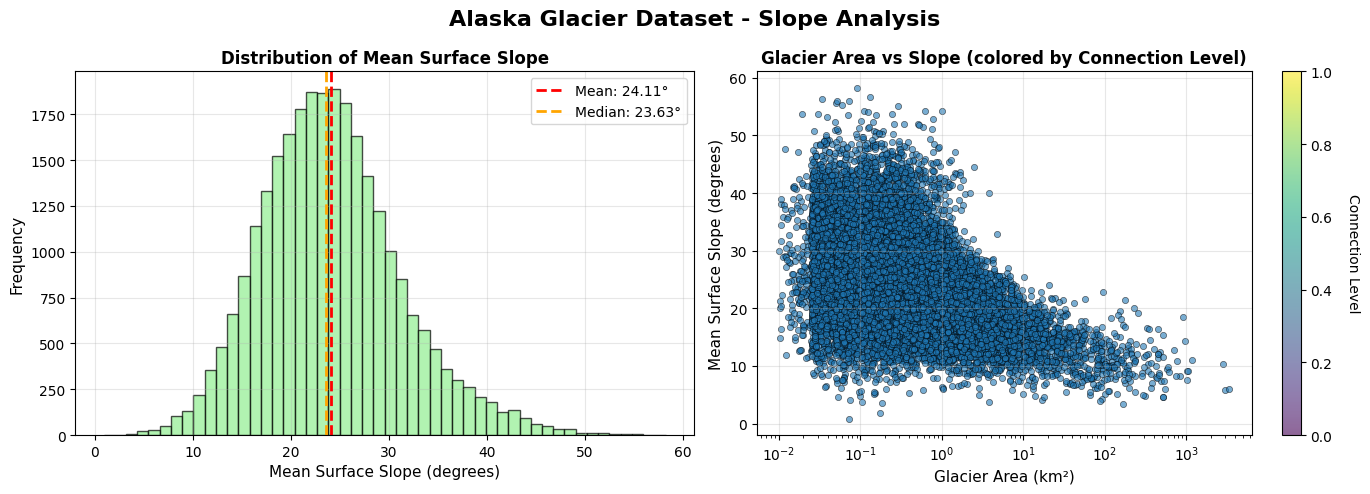

In [53]:
## Visualizing variables of interest

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Alaska Glacier Dataset - Slope Analysis', fontsize=16, fontweight='bold')

# 1. Histogram of Mean Surface Slope
ax1.hist(ds_alaska['slope_deg'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Mean Surface Slope (degrees)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Mean Surface Slope', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add statistics
mean_slope = ds_alaska['slope_deg'].mean()
median_slope = ds_alaska['slope_deg'].median()
ax1.axvline(mean_slope, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_slope:.2f}°')
ax1.axvline(median_slope, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_slope:.2f}°')
ax1.legend()

# 2. Scatter plot: Area vs Slope (colored by connection level)
scatter = ax2.scatter(ds_alaska['area_km2'], ds_alaska['slope_deg'], 
                     cmap='viridis', 
                     alpha=0.6, s=20, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Glacier Area (km²)', fontsize=11)
ax2.set_ylabel('Mean Surface Slope (degrees)', fontsize=11)
ax2.set_title('Glacier Area vs Slope (colored by Connection Level)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Connection Level', rotation=270, labelpad=20)

# Set log scale for area if there's high variation
if ds_alaska['area_km2'].max() / ds_alaska['area_km2'].min() > 100:
    ax2.set_xscale('log')

plt.tight_layout()
plt.show()

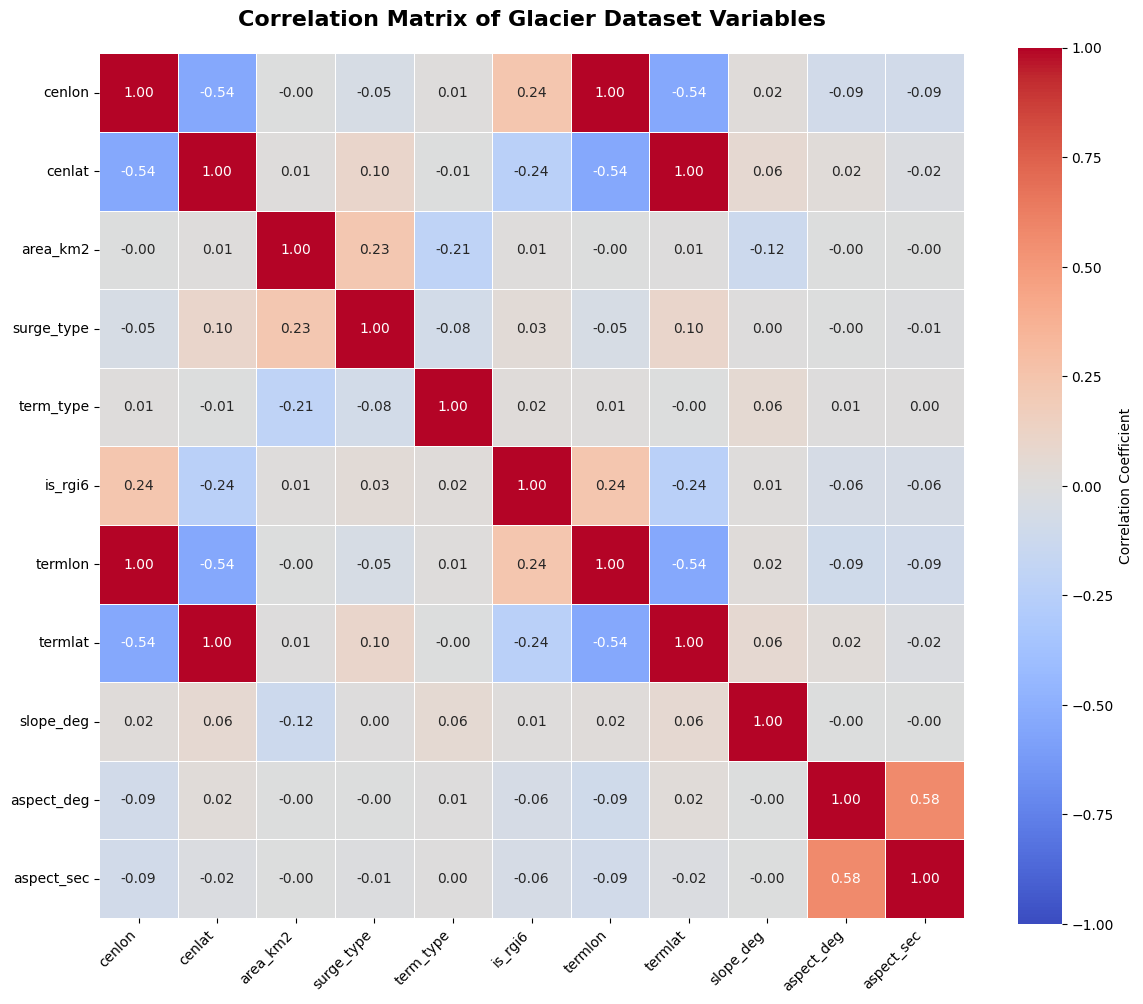

In [54]:
### Creating correlation matrix for all variables

# Select only numeric columns for correlation
numeric_cols = ds_alaska.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = ds_alaska[numeric_cols].corr()

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,           # Show correlation values
            fmt='.2f',            # Format to 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Add gridlines
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1,      # Set color scale from -1 to 1
            ax=ax)

ax.set_title('Correlation Matrix of Glacier Dataset Variables', 
             fontsize=16, fontweight='bold', pad=20)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


In [55]:
## PCA ANALYSIS

## dropping rows with NA
ds_alaska = ds_alaska.dropna() 
ds_alaska_centered = ds_alaska - ds_alaska.mean()

# Apply SVD to perform PCA (with centering to match sklearn)
U, S, Vt = np.linalg.svd(ds_alaska_centered, full_matrices = False)

# Project data onto principal components (scores)
pca_result = U * S

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(ds_alaska_centered) - 1)
explained_variance_ratio = explained_variance / explained_variance.sum()

# What proportion is variance is explained by each PC?
print("Explained variance:")
for i, var in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")


Explained variance:
  PC1: 0.8869 (88.69%)
  PC2: 0.1010 (10.10%)
  PC3: 0.0084 (0.84%)
  PC4: 0.0029 (0.29%)
  PC5: 0.0005 (0.05%)
  PC6: 0.0003 (0.03%)
  PC7: 0.0000 (0.00%)
  PC8: 0.0000 (0.00%)
  PC9: 0.0000 (0.00%)
  PC10: 0.0000 (0.00%)
  PC11: 0.0000 (0.00%)


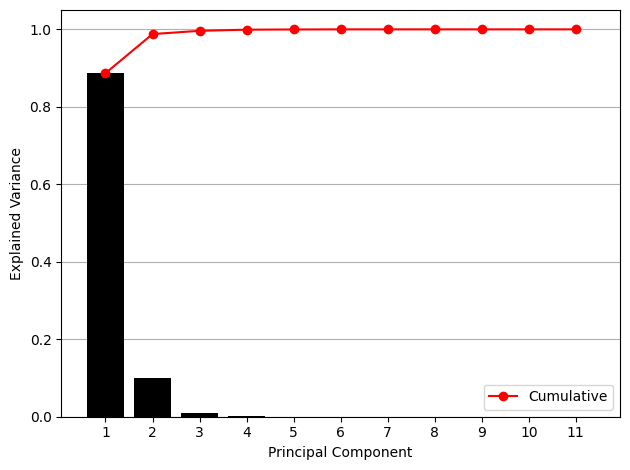

In [57]:
## Visualizing PCA results
fig, ax = plt.subplots()
ax.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 
       color='black')
ax.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), 
        'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_xticks(range(1, len(explained_variance_ratio)+1))
ax.legend()
ax.grid(True, axis='y')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

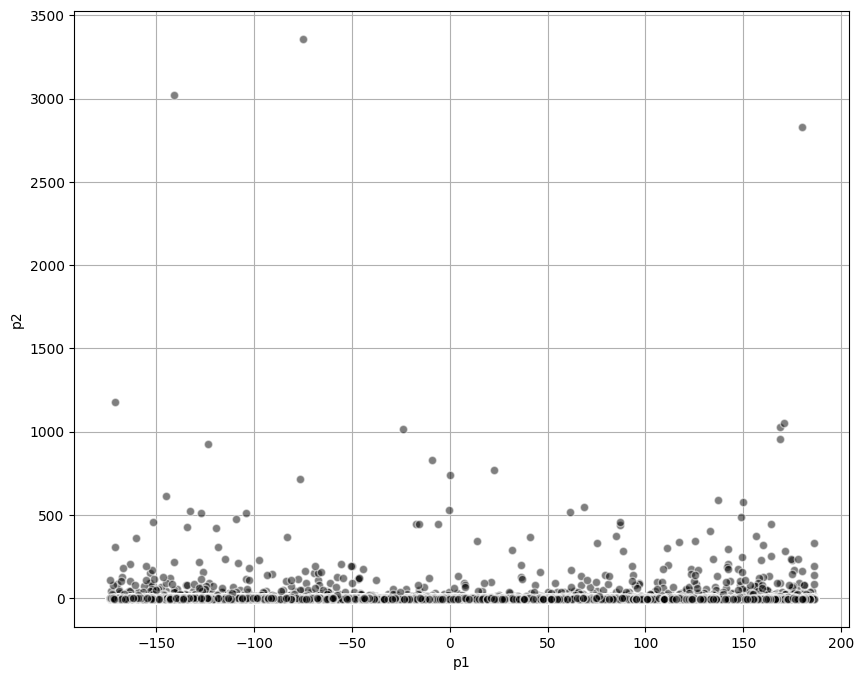

Correlation between p1 and p2: 0.000


In [59]:
#Visualizing PCA further
p1 = pca_result[:, 0]
p2 = pca_result[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(p1, p2, alpha=0.5, color='k', edgecolors='w')
ax.set_xlabel('p1')
ax.set_ylabel('p2')

ax.grid(True)
ax.set_axisbelow(True)
plt.show()

# Print correlation
correlation = np.corrcoef(p1, p2)[0, 1]
print(f"Correlation between p1 and p2: {correlation:.3f}")

In [60]:
# Loadings (principal component vectors) are the rows of Vt
loadings = pd.DataFrame(Vt.T, index = ds_alaska.columns, columns=[f'PC{i+1}' for i in range(Vt.shape[0])])
print("\nLoadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']])


Loadings for PC1 and PC2:
                 PC1       PC2
cenlon      0.006387 -0.000276
cenlat     -0.000510  0.000498
area_km2    0.001871  0.999771
surge_type  0.000013  0.002002
term_type  -0.000020 -0.001825
is_rgi6     0.000128  0.000051
termlon     0.006449 -0.000316
termlat    -0.000510  0.000414
slope_deg   0.000242 -0.021127
aspect_deg -0.999879  0.001861
aspect_sec -0.012497  0.000105


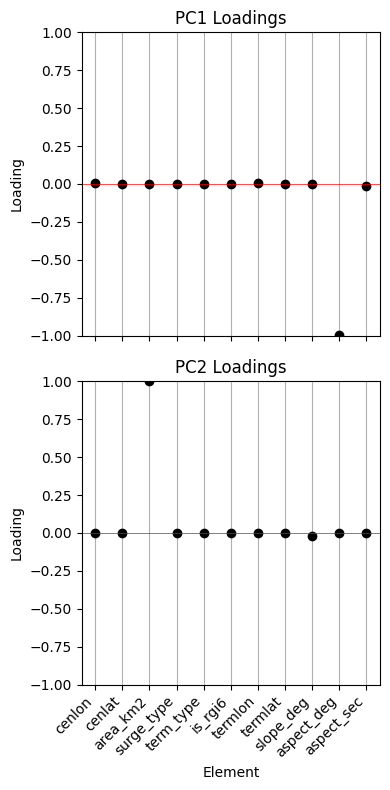

In [61]:
# Why don't we visualize these loadings?

alaska_cols = ds_alaska.columns

fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
x = np.arange(len(alaska_cols))
# latex_cols = [latex_labels[col] for col in geochem_cols]

# PC1 loadings
ax1 = axes[0]
ax1.scatter(x, loadings['PC1'], color='black')
ax1.set_ylabel('Loading')
ax1.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax1.set_ylim(-1, 1)
ax1.grid(True, axis='x')
ax1.set_axisbelow(True)
ax1.set_title('PC1 Loadings')

# PC2 loadings
ax2 = axes[1]
ax2.scatter(x, loadings['PC2'], color='black')
ax2.set_ylabel('Loading')
ax2.set_xlabel('Element')
ax2.set_xticks(x)
ax2.set_xticklabels(alaska_cols, rotation=45, ha='right')
ax2.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax2.set_ylim(-1, 1)
ax2.grid(True, axis='x')
ax2.set_axisbelow(True)
ax2.set_title('PC2 Loadings')

plt.tight_layout()
plt.show()